In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk import FreqDist

import string
from wordcloud import WordCloud,STOPWORDS
np.random.seed(1337)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import LSTM, Dense, Bidirectional, Embedding
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Using TensorFlow backend.


In [2]:
train_data = pd.read_csv('Data/train.tsv', sep = '\t')
test_data = pd.read_csv('Data/test.tsv', sep = '\t')

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156060 entries, 0 to 156059
Data columns (total 4 columns):
PhraseId      156060 non-null int64
SentenceId    156060 non-null int64
Phrase        156060 non-null object
Sentiment     156060 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66292 entries, 0 to 66291
Data columns (total 3 columns):
PhraseId      66292 non-null int64
SentenceId    66292 non-null int64
Phrase        66292 non-null object
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


In [9]:
Sentiment_words = []
for row in train_data['Sentiment']:
    if row == 0:
        Sentiment_words.append('negative')
    elif row == 1:
        Sentiment_words.append('somewhat negative')
    elif row == 2:
        Sentiment_words.append('neutral')
    elif row == 3:
        Sentiment_words.append('somewhat positive')
    elif row == 4:
        Sentiment_words.append('positive')
    else:
        Sentiment_words.append('Failed')
        
train_data['Sentiment_words'] = Sentiment_words

In [10]:
train_data.head()

,PhraseId,SentenceId,Phrase,Sentiment,Sentiment_words
0,1,1,A series of escapades demonstrating the adage ...,1,somewhat negative
1,2,1,A series of escapades demonstrating the adage ...,2,neutral
2,3,1,A series,2,neutral
3,4,1,A,2,neutral
4,5,1,series,2,neutral


In [11]:
sentiment_count = pd.value_counts(train_data['Sentiment_words'].values)
sentiment_count

neutral              79582
somewhat positive    32927
somewhat negative    27273
positive              9206
negative              7072
dtype: int64

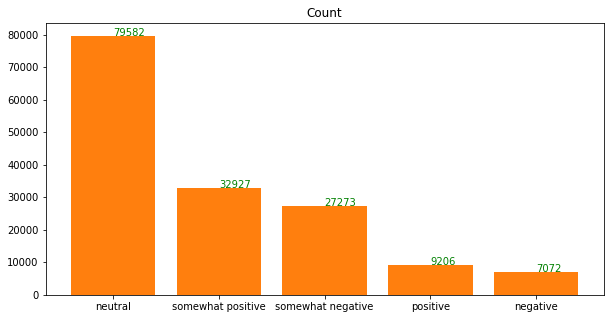

In [12]:
Idx = [1, 2, 3, 4, 5]
plt.figure(figsize = (10,5))
plt.bar(Idx, word_count)
plt.xticks(Idx, ['neutral','somewhat positive','somewhat negative','positive','negative'])
plt.title('Count')
plt.bar(Idx, word_count, color='green')
for a,b in zip(Idx, word_count):
    plt.text(a, b, str(b), color = 'black', fontsize=14)

## Data Preprocessing

In [21]:
lemmatizer = WordNetLemmatizer()

In [22]:
def get_wordnet_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [23]:
def text_processing(text):
    text = text.lower()
    text = ''.join([char for char in text if char not in string.punctuation])
    text = re.sub("[^a-zA-Z]"," ", text)
    words = text.split()
    stops = list(stopwords.words("english"))
    stops.remove('no')
    stops.remove('not')
    stops.remove('very')
    words = [w for w in words if not w in set(stops)]
    words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]
    return (' '.join(words))

In [21]:
train_data.Phrase = train_data.Phrase.apply(lambda x: text_processing(x))
test_data.Phrase = test_data.Phrase.apply(lambda x: text_processing(x))

In [22]:
train_data = train_data[train_data['Phrase'] != '']
test_data = test_data[test_data['Phrase'] != '']

In [26]:
train_data.to_csv("Data/Processed_train.tsv", columns = list(train_data.columns), index = False, sep = '\t')
test_data.to_csv("Data/Processed_test.tsv", columns = list(test_data.columns), index = False, sep = '\t')

## Data Visualization with WordCloud

In [31]:
words = ' '.join(train_data['Phrase'])
words = ' '.join([word for word in words.split()])

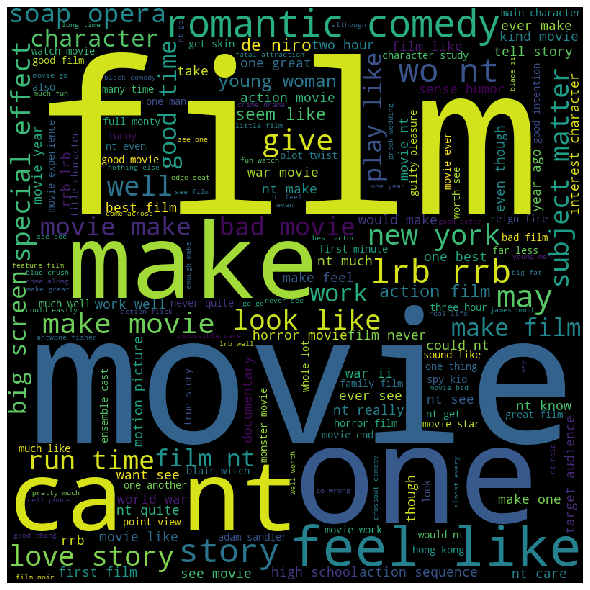

In [32]:
stops = set(stopwords.words("english"))

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='black', 
                stopwords = stops, 
                min_font_size = 10).generate(words) 

plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

## Data Tokenization and Embedding

In [2]:
training_data = pd.read_csv("Data/Processed_train.tsv", sep = '\t')
testing_data = pd.read_csv("Data/Processed_test.tsv", sep = '\t')

In [3]:
train_X = training_data['Phrase'].values
train_Y = to_categorical(training_data['Sentiment'].values)
test_X = testing_data['Phrase'].values
print(train_X.shape, train_Y.shape, test_X.shape)

(154741,) (154741, 5) (65597,)


In [4]:
all_words = ' '.join(train_X)
all_words = word_tokenize(all_words)
dist = FreqDist(all_words)
num_unique_word = len(dist)
num_unique_word

13493

In [5]:
r_len = []
for text in train_X:
    word = word_tokenize(text)
    l = len(word)
    r_len.append(l)
    
max_rlen = np.max(r_len)
max_rlen

30

In [7]:
max_features = num_unique_word
max_words = 100
batch_size = 64
epochs = 10
num_classes = 5

In [8]:
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(train_X)

In [9]:
train_X, val_X, train_Y, val_Y = train_test_split(train_X, train_Y, test_size=0.1, stratify = train_Y ,random_state=123)
print(train_X.shape,train_Y.shape)
print(val_X.shape,val_Y.shape)

(139266,) (139266, 5)
(15475,) (15475, 5)


In [10]:
def Tokenization(texts):
    data = tokenizer.texts_to_sequences(texts)
    data = pad_sequences(data, maxlen = max_words)
    return data

In [11]:
train_X = Tokenization(train_X)
val_X = Tokenization(val_X)
test_X = Tokenization(test_X)

In [12]:
print(train_X.shape,val_X.shape,test_X.shape)

(139266, 100) (15475, 100) (65597, 100)


In [13]:
def get_embed_mat(EMBEDDING_FILE, max_features, embed_dim):
    embedding_index = {}

    with open(EMBEDDING_FILE, encoding='utf8') as f:
        for line in f:
            values = line.rstrip().rsplit(' ')
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embedding_index[word] = coefs
    
    word_index = tokenizer.word_index
    num_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.zeros((num_words, embed_dim))
    
    for word, i in word_index.items():
        if i >= max_features:
            continue
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
        else:
            embedding_matrix[i] = np.random.randn(embed_dim)
    max_features = embedding_matrix.shape[0]
    
    return embedding_matrix

In [14]:
EMBEDDING_FILE = 'glove.6B.100d.txt'
embed_dim = 100
embedding_matrix = get_embed_mat(EMBEDDING_FILE, max_features, embed_dim)

In [15]:
print(embedding_matrix.shape)

(13493, 100)


## Model Definition and Training

In [16]:
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length = train_X.shape[1], weights = [embedding_matrix], trainable=True))
model.add(Bidirectional(LSTM(32, dropout=0.4, recurrent_dropout=0.4)))
model.add(Dense(100,activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1349300   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 128)          84480     
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 1,475,321
Trainable params: 1,475,321
Non-trainable params: 0
_________________________________________________________________


In [17]:
weight_filepath = 'Data/weights_GloVe.hdf5'
checkpoint = ModelCheckpoint(
    weight_filepath,
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(min_delta = 0.001, mode = 'max', monitor='val_acc', patience = 2)

callbacks_list = [checkpoint, early_stopping]
model.load_weights(weight_filepath)

history = model.fit(train_X, train_Y, validation_data = (val_X, val_Y), epochs = epochs, batch_size = batch_size, verbose = 1, callbacks = callbacks_list)



c:\users\hp\appdata\local\programs\python\python37\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 139266 samples, validate on 15475 samples
Epoch 1/10
139266/139266 [==============================] - 2075s 15ms/step - loss: 0.9939 - accuracy: 0.5919 - val_loss: 0.8724 - val_accuracy: 0.6379
Epoch 2/10
139266/139266 [==============================] - 2477s 18ms/step - loss: 0.8635 - accuracy: 0.6423 - val_loss: 0.8344 - val_accuracy: 0.6532
Epoch 3/10
139266/139266 [==============================] - 1608s 12ms/step - loss: 0.8121 - accuracy: 0.6639 - val_loss: 0.8178 - val_accuracy: 0.6646
Epoch 4/10
139266/139266 [==============================] - 657s 5ms/step - loss: 0.7795 - accuracy: 0.6768 - val_loss: 0.8043 - val_accuracy: 0.6706
Epoch 5/10
139266/139266 [==============================] - 661s 5ms/step - loss: 0.7522 - accuracy: 0.6896 - val_loss: 0.8027 - val_accuracy: 0.6655
Epoch 6/10
139266/139266 [==============================] - 1156s 8ms/step - loss: 0.7333 - accuracy: 0.6958 - val_loss: 0.8022 - val_accuracy: 0.6649
Epoch 7/10
139266/139266 [================

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])


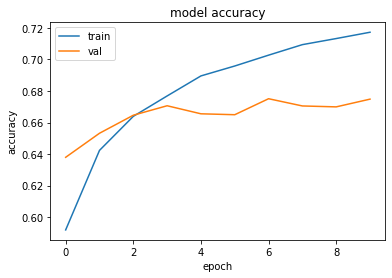

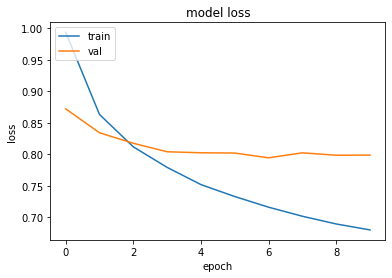

In [18]:
print(history.history.keys())

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [27]:
print(test_X.shape)
weight_filepath = 'weights_Final.hdf5'
model.load_weights(weight_filepath)
review = "worst movie ever"

processed_review = [text_processing(review)]
print(processed_review)
tokenized_review = Tokenization(processed_review)
sentiment = model.predict_classes(tokenized_review)
print(sentiment)

(65597, 100)
['bad movie ever']
[0]


In [ ]:
#make the predictions with trained model and submit the predictions.
y_pred=model.predict_classes(test_X)

sub_file = pd.read_csv('Data/sampleSubmission.csv',sep=',')
sub_file.Sentiment=y_pred
sub_file.to_csv('Submission.csv',index=False)